In [4]:
import numpy as np
X = [[2,0,-1.4],[2.2,0.2,-1.5],[2.4,0.1,-1]]

# 从线性回归到逻辑回归

在第2章，线性回归里面，我们介绍了一元线性回归，多元线性回归和多项式回归。这些模型都是广义线性回归模型的具体形式，广义线性回归是一种灵活的框架，比普通线性回归要求更少的假设。这一章，我们讨论广义线性回归模型的具体形式的另一种形式，逻辑回归（logistic regression）。

和前面讨论的模型不同，逻辑回归是用来做分类任务的。分类任务的目标是找一个函数，把观测值匹配到相关的类和标签上。学习算法必须用成对的特征向量和对应的标签来估计匹配函数的参数，从而实现更好的分类效果。在二元分类（binary classification）中，分类算法必须把一个实例配置两个类别。二元分类案例包括，预测患者是否患有某种疾病，音频中是否含有人声，杜克大学男子篮球队在NCAA比赛中第一场的输赢。多元分类中，分类算法需要为每个实例都分类一组标签。本章，我们会用逻辑回归来介绍一些分类算法问题，研究分类任务的效果评价，也会用到上一章学的特征抽取方法。

###  逻辑回归处理二分类
普通的线性回归假设响应变量呈正态分布，也称为高斯分布（Gaussian distribution ）或钟形曲线（bell curve）。正态分布数据是对称的，且均值，中位数和众数（mode）是一样的。很多自然现象都服从正态分布。比如，人类的身高就服从正态分布，姚明那样的高度极少，在99%之外了。

在某些问题里，响应变量不是正态分布的。比如，掷一个硬币获取正反两面的概率分布是伯努力分布（Bernoulli distribution），又称两点分布或者0-1分布。表示一个事件发生的概率是$P$，不发生的概率是$1-P$，概率在{0,1}之间。线性回归假设解释变量值的变化会引起响应变量值的变化，如果响应变量的值是概率的，这条假设就不满足了。广义线性回归去掉了这条假设，用一个联连函数(link function)来描述解释变量与响应变量的关系。实际上，在第2章，线性回归里面，我们已经用了联连函数。普通线性回归作为广义线性回归的特例使用的是恒等联连函数(identity link function)，将解释变量的通过线性组合的方式来联接服从正态分布的响应变量。如果响应变量不服从正态分布，就要用另外一种联连函数了。

在逻辑回归里，响应变量描述了类似于掷一个硬币结果为正面的概率。如果响应变量等于或超过了指定的临界值，预测结果就是正面，否则预测结果就是反面。响应变量是一个像线性回归中的解释变量构成的函数表示，称为逻辑函数（logistic function）。一个值在{0,1}之间的逻辑函数如下所示：
$$F(t)=\frac 1 {1+e^{-t}}$$

In [1]:
# 函数的图形如下所示
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"/Library/Fonts/Microsoft/Fangsong.ttf", size=10)

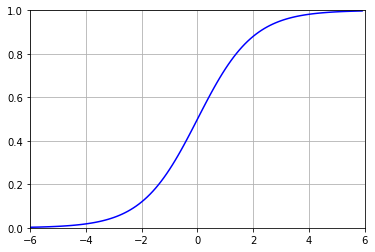

In [2]:
import numpy as np
plt.figure()
plt.axis([-6, 6, 0, 1])
plt.grid(True)
X = np.arange(-6,6,0.1)
y = 1 / (1 + np.e ** (-X))
plt.plot(X, y, 'b-')

在逻辑回归中，$$t$$是解释变量的线性组合，公式如下：
$$F(t)=\frac 1 {1+e^{-(\beta_0+\beta_x)}}$$
对数函数（logit function）是逻辑函数的逆运算：

$$g(x)=ln {\frac {F(x)} {1-F(x)}} = \beta_0+\beta_x$$
定义了逻辑回归的模型之后，我们用它来完成一个分类任务。
### 垃圾邮件分类¶
经典的二元分类问题就是垃圾邮件分类（spam classification）。这里，我们分类垃圾短信。我们用第三章介绍的TF-IDF算法来抽取短信的特征向量，然后用逻辑回归分类。

我们可以用UCI Machine Learning Repository的短信垃圾分类数据集（SMS Spam Classification Data Set）。首先，我们还是用Pandas做一些描述性统计

In [4]:
import pandas as pd
df = pd.read_csv('SMSSpamCollection.txt', delimiter='\t', header=None)
print(df.head())
print('含spam短信数量：', df[df[0] == 'spam'][0].count())
print('含ham短信数量：', df[df[0] == 'ham'][0].count())

      0                                                  1
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
含spam短信数量： 747
含ham短信数量： 4825


每条信息的前面已经被打上了标签。共5574条短信里面，4827条是ham，747条是spam。ham短信用0标记，spam短信用1标记。观察数据会看到更多建模时需要的信息。下面的几条信息体现两种类型的特征：

Spam: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May
Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Spam: WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
Ham: Sorry my roommates took forever, it ok if I come by now?
Ham: Finished class where are you.
让我们用LogisticRegression类来预测：

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.cross_validation import train_test_split

/Users/zp/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


首先，用pandas加载数据.csv文件，然后用train_test_split分成训练集（75%）和测试集（25%）：

In [6]:
df = pd.read_csv('SMSSpamCollection.txt', delimiter='\t', header=None)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(df[1],
df[0])

In [7]:
#然后，我们建一个TfidfVectorizer实例来计算TF-IDF权重：
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

最后，我们建一个LogisticRegression实例来训练模型。和LinearRegression类似，LogisticRegression同样实现了fit()和predict()方法。最后把结果打印出来看看：

In [8]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

In [9]:
for i, prediction in enumerate(predictions[-5:]):
    print('预测类型：%s. 信息：%s' % (prediction, X_test_raw.iloc[i]))

预测类型：ham. 信息：God bless.get good sleep my dear...i will pray!
预测类型：ham. 信息：Living is very simple.. Loving is also simple.. Laughing is too simple.. Winning is tooo simple.. But, being 'SIMPLE' is very difficult.. Gud nte.:-
预测类型：ham. 信息：Once a fishrman woke early in d mrng. It was very dark. He waited a while &amp; found a sack ful of stones. He strtd throwin thm in2 d sea 2 pass time. Atlast he had jus 1stone, sun rose up &amp; he found out tht those r nt stones, those were diamonds. Moral:"Dont wake up early in d mrng'' GOOD night
预测类型：ham. 信息：jay says he'll put in  &lt;#&gt;
预测类型：ham. 信息：Aldrine, rakhesh ex RTM here.pls call.urgent.


分类模型的运行效果如何？有线性回归的度量方法在这里不太适用了。我们感兴趣的是分类是否正确（如第一章介绍的肿瘤预测问题），并不在乎它的决策范围。下面，我们来介绍二元分类的效果评估方法。

### 二元分类效果评估方法
二元分类的效果评估方法有很多，常见的包括第一章里介绍的肿瘤预测使用的准确率（accuracy），精确率（precision）和召回率（recall）三项指标，以及综合评价指标（F1 measure）， ROC AUC值（Receiver Operating Characteristic ROC，Area Under Curve，AUC）。这些指标评价的样本分类是真阳性（true positives），真阴性（true negatives），假阳性（false positives），假阴性（false negatives）。阳性和阴性指分类，真和假指预测的正确与否。

在我们的垃圾短信分类里，真阳性是指分类器将一个垃圾短信分辨为spam类。真阴性是指分类器将一个正常短信分辨为ham类。假阳性是指分类器将一个正常短信分辨为spam类。假阴性是指分类器将一个垃圾短信分辨为ham类。混淆矩阵（Confusion matrix），也称列联表分析（Contingency table）可以用来描述真假与阴阳的关系。矩阵的行表示实际类型，列表示预测类型。

[[4 1]
 [2 3]]


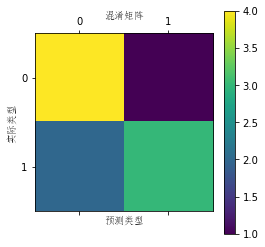

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
y_test = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
y_pred = [0, 1, 0, 0, 0, 0, 0, 1, 1, 1]
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
plt.matshow(confusion_matrix)
plt.title('混淆矩阵',fontproperties=font)
plt.colorbar()
plt.ylabel('实际类型',fontproperties=font)
plt.xlabel('预测类型',fontproperties=font)
plt.show()

#### 准确率
准确率是分类器预测正确性的评估指标。scikit-learn提供了accuracy_score来计算：

In [11]:
from sklearn.metrics import accuracy_score
y_pred, y_true = [0, 1, 1, 0], [1, 1, 1, 1]
print(accuracy_score(y_true, y_pred))

0.5


### LogisticRegression.score()用来计算模型预测的准确率：


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score

df = pd.read_csv('SMS')
X_train_raw, X_test_raw, y_train, y_test = train_test_split(df['message'], df['label'])
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
scores = cross_val_score(classifier, X_train, y_train, cv=5)
print('准确率：',np.mean(scores), scores)

你的结果可能和这些数字不完全相同，毕竟交叉检验的训练集和测试集都是随机抽取的。准确率是分类器预测正确性的比例，但是并不能分辨出假阳性错误和假阴性错误。在有些问题里面，比如第一章的肿瘤预测问题中，假阴性与假阳性要严重得多，其他的问题里可能相反。另外，有时准确率并非一个有效的衡量指标，如果分类的比例在样本中严重失调。比如，分类器预测信用卡交易是否为虚假交易时，假阴性比假阳性更敏感。为了提高客户满意度，信用卡部门更倾向于对合法的交易进行风险检查，往往会忽略虚假交易。因为绝大部分交易都是合法的，这里准确率不是一个有效的衡量指标。经常预测出虚假交易的分类器可能有很高的准确率，但是实际情况可能并非如此。因此，分类器的预测效果还需要另外两个指标：精确率和召回率。

精确率和召回率
第一章的肿瘤预测问题中精确率和召回率的定义我们已经介绍过。在本章的垃圾短信分类器中，精确率是指分类器预测出的垃圾短信中真的是垃圾短信的比例：

$$P = \frac {TP} {TP+FP}$$
召回率在医学领域也叫做灵敏度（sensitivity），在本例中是指所有真的垃圾短信被分类器正确找出来的比例。

$$R = \frac {TP} {TP+FN}$$
精确率和召回率各自含有的信息都很少，它们对分类器效果的观察角度不同。精确率和召回率都不能从表现差的一种分类器中区分出好的分类器。例如，假设一个测试集包括10个阳性和0个阴性结果。分类器即使将每一个样本都预测为阳性，其召回率都是1：

$$R = \frac {10} {10+0}=1$$
分类器如果将每一个样本都预测为阴性，或者只是预测出假阳性和真阴性，其召回率都是0。类似的，一个分类器如果只预测一个样本，结果为阳性，而且这个样本确实为阳性，那么这个分类器就是100%精确的了。

scikit-learn结合真实类型数据，提供了一个函数来计算一组预测值的精确率和召回率。

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score

df = pd.read_csv('mlslpic/sms.csv')
X_train_raw, X_test_raw, y_train, y_test = train_test_split(df['message'], df['label'])
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
precisions = cross_val_score(classifier, X_train, y_train, cv=5, scoring='precision')
print('精确率：', np.mean(precisions), precisions)
recalls = cross_val_score(classifier, X_train, y_train, cv=5, scoring='recall')
print('召回率：', np.mean(recalls), recalls)

我们的分类器精确率99.2%，分类器预测出的垃圾短信中99.2%都是真的垃圾短信。召回率比较低67.2%，就是说真实的垃圾短信中，32.8%被当作正常短信了，没有被识别出来。这些数据会不断变化，因为训练集和测试集是随机抽取的。

计算综合评价指标
综合评价指标（F1 measure）是精确率和召回率的调和均值（harmonic mean），或加权平均值，也称为F-measure或fF-score。

$$\frac 1 {F1} + \frac 1 {F1} = \frac 1 P + \frac 1 R $$
即

$$F1 = 2{\frac {PR} {P+R}}$$
综合评价指标平衡了精确率和召回率。一个二元分类模型，精确率和召回率为1，那么综合评价指标为1。如果精确率或召回率为0，那么综合评价指标为0。scikit-learn也提供了计算综合评价指标的函数。

In [ ]:
f1s = cross_val_score(classifier, X_train, y_train, cv=5, scoring='f1')
print('综合评价指标：', np.mean(f1s), f1s)

本例的综合评价指标是80%。由于精确率和召回率的差异比较小，所以综合评价指标的罚值也比较小。有时也会用F0.5和F2，表示精确率权重大于召回率，或召回率权重大于精确率。

ROC AUC
ROC曲线（Receiver Operating Characteristic，ROC curve）可以用来可视化分类器的效果。和准确率不同，ROC曲线对分类比例不平衡的数据集不敏感，ROC曲线显示的是对超过限定阈值的所有预测结果的分类器效果。ROC曲线画的是分类器的召回率与误警率（fall-out）的曲线。误警率也称假阳性率，是所有阴性样本中分类器识别为阳性的样本所占比例：

$$F = \frac {FP} {TN+FP}$$
AUC是ROC曲线下方的面积，它把ROC曲线变成一个值，表示分类器随机预测的效果。scikit-learn提供了计算ROC和AUC指标的函数

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc

df = pd.read_csv('mlslpic/sms.csv')
X_train_raw, X_test_raw, y_train, y_test = train_test_split(df['message'], df['label'])
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
predictions = classifier.predict_proba(X_test)
false_positive_rate, recall, thresholds = roc_curve(y_test, predictions[:, 1])
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

### 网格搜索
在第二章我们曾经提到过超参数，是需要手动调节的参数，模型无法学习。比如，在我们的垃圾短信分类模型中，超参数出现在TF-IDF中，用来移除太频繁和太稀缺单词的频率阈值，目前函数正则化的权重值。在scikit-learn里面，超参数是在模型建立时设置的。在前面的例子中，我们没有为LogisticRegression()设置参数，是因为用的都是默认值。但是有时候默认值不一定是最优的。网格搜索（Grid search）就是用来确定最优超参数的方法。其原理就是选取可能的参数不断运行模型获取最佳效果。网格搜索用的是穷举法，其缺点在于即使每个超参数的取值范围都很小，计算量也是巨大的。不过这是一个并行问题，参数与参数彼此独立，计算过程不需要同步，所有很多方法都可以解决这个问题。scikit-learn有GridSearchCV()函数解决这个问题：

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score

pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression())
])
parameters = {
    'vect__max_df': (0.25, 0.5, 0.75),
    'vect__stop_words': ('english', None),
    'vect__max_features': (2500, 5000, 10000, None),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'vect__use_idf': (True, False),
    'vect__norm': ('l1', 'l2'),
    'clf__penalty': ('l1', 'l2'),
    'clf__C': (0.01, 0.1, 1, 10),
}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='accuracy', cv=3)

df = pd.read_csv('mlslpic/sms.csv')
X, y, = df['message'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y)
grid_search.fit(X_train, y_train)
print('最佳效果：%0.3f' % grid_search.best_score_)
print('最优参数组合：')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))
predictions = grid_search.predict(X_test)
print('准确率：', accuracy_score(y_test, predictions))
print('精确率：', precision_score(y_test, predictions))
print('召回率：', recall_score(y_test, predictions))

GridSearchCV()函数的参数有待评估模型pipeline，超参数词典parameters和效果评价指标scoring。n_jobs是指并发进程最大数量，设置为-1表示使用所有CPU核心进程。在Python3.4中，可以写一个Python的脚本，让fit()函数可以在main()函数里调用，也可以在Python自带命令行,IPython命令行和IPython Notebook运行。经过网格计算后的超参数在训练集中取得了很好的效果。

## 多类分类
现实中有很多问题不只是分成两类，许多问题都需要分成多个类，成为多类分类问题（Multi-class classification）。比如听到一首歌的样曲之后，可以将其归入某一种音乐风格。这类风格就有许多种。scikit-learn用one-vs.-all或one-vs.-the-rest方法实现多类分类，就是把多类中的每个类都作为二元分类处理。分类器预测样本不同类型，将具有最大置信水平的类型作为样本类型。LogisticRegression()通过one-vs.-all策略支持多类分类。下面，我们用它来分析一个多类分类问题。

假设你想看电影，而你又非常讨厌看太次的电影。所以有品位的你可以在看每部电影之前都会看一堆影评，不过你更讨厌看影评。那么下面我们就用好影评来给电影分类。

本例中，我们利用烂番茄（Rotten Tomatoes）网站影评短语数据对电影进行评价。每个影评可以归入下面5个类项：不给力（negative），不太给力（somewhat negative），中等（neutral），有点给力（somewhat positive）, 给力（positive）。解释变量不会总是直白的语言，因为影评内容千差万别，有讽刺的，否定的，以及其他语义的表述，语义并不直白，这些都会让分类充满挑战。数据集可以从kaggle上下载。首先，我们还是用Pandas简单探索一下：

In [ ]:
import zipfile
# 压缩节省空间
z = zipfile.ZipFile('mlslpic/train.zip')
df = pd.read_csv(z.open(z.namelist()[0]), header=0, delimiter='\t')

In [ ]:

In [37]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
import zipfile

pipeline = Pipeline([
    ('vect', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression())
])
parameters = {
    'vect__max_df': (0.25, 0.5),
    'vect__ngram_range': ((1, 1), (1, 2)),
    'vect__use_idf': (True, False),
    'clf__C': (0.1, 1, 10),
}

z = zipfile.ZipFile('mlslpic/train.zip')
df = pd.read_csv(z.open(z.namelist()[0]), header=0, delimiter='\t')
X, y = df['Phrase'], df['Sentiment'].as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
grid_search = GridSearchCV(pipeline, parameters, n_jobs=3, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)
print('最佳效果：%0.3f' % grid_search.best_score_)
print('最优参数组合：')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

In [ ]:
predictions = grid_search.predict(X_test)
print('准确率：', accuracy_score(y_test, predictions))
print('混淆矩阵：', confusion_matrix(y_test, predictions))
print('分类报告：', classification_report(y_test, predictions))

In [5]:
# np.cov() 求解一个矩阵的协方差矩阵
print(np.cov(np.array(X).T))

[[ 0.04   0.01   0.04 ]
 [ 0.01   0.01  -0.005]
 [ 0.04  -0.005  0.07 ]]


In [6]:
## 求解一个矩阵的特征向量 特征值
import numpy as np
w,v = np.linalg.eig(np.array([[1,-2],[2,-3]]))
print("特征值：{},\n特征向量：{}".format(w,v))

特征值：[-0.99999998 -1.00000002],
特征向量：[[ 0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]


##  感知器

In [11]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Perceptron
categories = ['rec.sport.hockey', 'rec.sport.baseball', 'rec.autos'] 
newsgroups_train = fetch_20newsgroups(subset='train', 
                                      categories=categories,
                                      remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', 
                                     categories=categories , 
                                     remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(newsgroups_train.data) 
X_test = vectorizer.transform(newsgroups_test.data)
classifier = Perceptron(n_iter=100, eta0=0.1) 
classifier.fit(X_train, newsgroups_train.target) 
predictions = classifier.predict(X_test) 
print(classification_report(newsgroups_test.target, predictions))

             precision    recall  f1-score   support

          0       0.85      0.92      0.89       396
          1       0.85      0.81      0.83       397
          2       0.89      0.86      0.87       399

avg / total       0.86      0.86      0.86      1192



/Users/zp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


##   SVM


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata 
import matplotlib.cm as cm
digits = fetch_mldata('MNIST original', data_home='data/mnist').data
counter = 1
for i in range(1, 4):
    for j in range(1, 6):
        plt.subplot(3, 5, counter)
        plt.imshow(digits[(i - 1) * 8000 + j].reshape((28, 28)), cmap=cm.Greys_r) 
        plt.axis('off')
        counter += 1
plt.show()